# ITL Recursive CNNs - inference + evaluation
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kakainet/TexNet/blob/master/ITL_recursive_CNNs.ipynb)

In [1]:
#Run once per session
%load_ext autoreload
%autoreload 2
!pip install -q fastcore==1.2.5
!pip install -q fastai==2.0.16

     |████████████████████████████████| 51kB 3.1MB/s 
     |████████████████████████████████| 194kB 4.8MB/s 


# Dataset loading + initialization

In [2]:
from fastai.vision.all import *

In [3]:
VERSION=13
ITL_DS_NAME = f'itl_dataset_v{VERSION}.zip'
ITL_DS_URL =  f'http://students.mimuw.edu.pl/~mt406390/machine_learning/' + ITL_DS_NAME
!wget $ITL_DS_URL
!unzip -qq $ITL_DS_NAME -d data/
path = Path('data')

--2020-11-02 17:20:47--  http://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v13.zip
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v13.zip [following]
--2020-11-02 17:20:47--  https://students.mimuw.edu.pl/~mt406390/machine_learning/itl_dataset_v13.zip
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13406847 (13M) [application/zip]
Saving to: ‘itl_dataset_v13.zip’

itl_dataset_v13.zip 100%[===================>]  12.79M  6.35MB/s    in 2.0s    

2020-11-02 17:20:49 (6.35 MB/s) - ‘itl_dataset_v13.zip’ saved [13406847/13406847]



In [4]:
path.ls()

(#9) [Path('data/itl_labels.txt'),Path('data/operators.txt'),Path('data/output_black'),Path('data/depths.txt'),Path('data/output_bbox'),Path('data/output_proper'),Path('data/output_color'),Path('data/annotations.json'),Path('data/job.json')]

In [5]:
with open(path / 'annotations.json') as f:
    annots = json.load(f)
print(len(annots))

800


In [6]:
images = list(x['name'] for x in annots if len(x['exprs']) > 0)
print(len(images))
images[0]

800


'eq0.png'

In [7]:
ops_cfg = {
  "leaf": {
    "latex": "{0}",
    "operands": 0,
    "inline": true
  },
  "add": {
    "latex": "{0} + {1}",
    "operands": 2,
    "inline": true
  },
  "times": {
    "latex": "{0} \\times {1}",
    "operands": 2,
    "inline": true
  },
  "star": {
    "latex": "{0} \\star {1}",
    "operands": 2,
    "inline": true
  },
  "div": {
    "latex": "{0} \\div {1}",
    "operands": 2,
    "inline": true
  },
  "otimes": {
    "latex": "{0} \\otimes {1}",
    "operands": 2,
    "inline": true
  },
  "sub": {
    "latex": "{0} - {1}",
    "operands": 2,
    "inline": true
  },
  "mul": {
    "latex": "{0} \\cdot {1}",
    "operands": 2,
    "inline": true
  },
  "frac": {
    "latex": "\\frac {{ {0} }} {{ {1} }}",
    "operands": 2
  },
  "sqrt": {
    "latex": "\\sqrt {{ {0} }}",
    "operands": 1
  },
  "int": {
    "latex": "\\int \\left( {0} \\right)",
    "operands": 1
  },
  "sum": {
    "latex": "\\sum \\left( {0} \\right)",
    "operands": 1
  },
  "pi": {
    "latex": "\\prod \\left( {0} \\right)",
    "operands": 1
  },
  "par": {
    "latex": "\\left( {0} \\right)",
    "operands": 1
  },
  "fpar": {
    "latex": "f \\left( {0} \\right)",
    "operands": 1
  },
  "ffpar": {
    "latex": "F \\left( {0} \\right)",
    "operands": 1
  },
  "gpar": {
    "latex": "G \\left( {0} \\right)",
    "operands": 1
  }
}

Next, we want to be able to quickly look up a corresponding image to it's label. We'll use a dictionary

In [8]:
img2bbox = dict(zip(images, annots))

Great! Now let's build our `DataBlock`. We'll have two outputs, the bounding box itself and a label, with one input. For our `y`'s, we'll define some `getters`. The first of which will be `noop`, as we don't care about our initial image, and then we'll grab our label and bbox coordinates (we'll also define our `get_items`)

In [9]:
def bbox_to_fastai(box):
    x, y, dx, dy = box
    return [x, y, x + dx, y + dy]

getters = [
    lambda o: path/'output_proper'/o, lambda o: list(map(bbox_to_fastai, img2bbox[o]['exprs'])),
    lambda o: len(img2bbox[o]['exprs']) * [img2bbox[o]['op']]
]

For our transforms, we'll use some of the ones we defined earlier

In [10]:
item_tfms = []
batch_tfms = [Zoom(0.6, 1.5), Warp(0.25), Saturation(max_lighting=0.5),
              Brightness(), Rotate()]

Why do we need a custom `get_images`? Because we want our **images** that came back to us, not the entire folder

In [11]:
def get_train_imgs(noop):  return images

We'll now make our `DataBlock`. We want to adjust `n_inp` as we expect two outputs

In [12]:
pascal = DataBlock(blocks=(ImageBlock(cls=PILImageBW), BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(0.3),
                 get_items=get_train_imgs, 
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [13]:
BS = 16
dls = pascal.dataloaders('', bs=BS)
dls.c = len(ops_cfg)

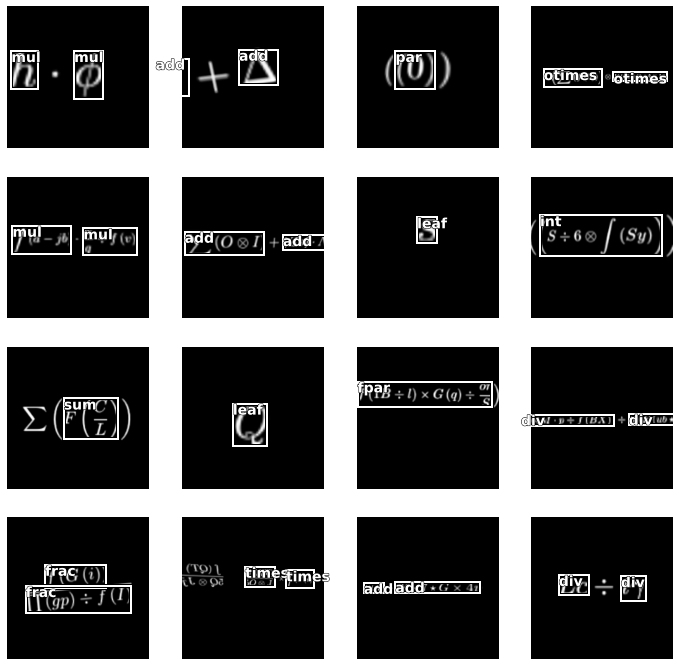

In [14]:
dls.show_batch(max_n=25)

# ITL model

In [15]:
POINTS_PER_BBOX = 4
N_BBOXES = 2
BBOXES = N_BBOXES * POINTS_PER_BBOX
CATS = dls.c
OUT = CATS + BBOXES

In [16]:
head = nn.Sequential(
    nn.Conv2d(512, 128, 3, 2),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, OUT, 3, 1),
    nn.Flatten()
)

cfg = cnn_config(n_in=1, custom_head=head)

In [17]:
from torchvision.ops import box_iou

def encode_boxes(boxes_points):
    boxes_points = (boxes_points + 1) / 2
    x1, y1, x2, y2 = boxes_points[..., 0], boxes_points[..., 1], boxes_points[..., 2], boxes_points[..., 3]
    return torch.stack((x1, y1, torch.sqrt(x2 - x1), torch.sqrt(y2 - y1)), dim=-1)
    
def decode_boxes(boxes_lens):
    x, y, dx, dy = boxes_lens[..., 0], boxes_lens[..., 1], torch.square(boxes_lens[..., 2]), torch.square(boxes_lens[..., 3])
    boxes_points = torch.stack((x, y, x + dx, y + dy), dim=-1)
    return 2 * boxes_points - 1

class MseAndCrossEntropy(Module):
    def forward(self, pred, target_bboxes, target_cat):
        bboxes_preds = torch.sigmoid(pred[..., CATS:]).view((-1, N_BBOXES, POINTS_PER_BBOX))
        mask = (target_cat > 0)

        box_loss = F.mse_loss(bboxes_preds[mask], target_bboxes[mask])
        ce_loss = F.cross_entropy(pred[..., :CATS], target_cat[..., 0] - 1)
        return ce_loss + 50 * torch.sqrt(box_loss)

def ops_accuracy(pred, target_bboxes, target_cat):
    return accuracy(pred[..., :CATS], target_cat[..., 0] - 1)
    
def boxes_iou(pred, target_bboxes, target_cat):
    bboxes_preds = torch.sigmoid(pred[..., CATS:]).view((-1, N_BBOXES, POINTS_PER_BBOX))
    bboxes_decoded = decode_boxes(bboxes_preds)

    mask = (target_cat > 0)
    x, y = bboxes_decoded[mask], target_bboxes[mask]
    ious = torch.diagonal(box_iou(x, y))
    return ious.mean()


@log_args
class ITLLoss(BaseLoss):
    def __init__(self, *args, axis=-1, **kwargs):
        super().__init__(MseAndCrossEntropy, *args, axis=axis, **kwargs)

    def __call__(self, inp, targ, labels, **kwargs):
        targ_encoded = encode_boxes(targ)

        return self.func.__call__(inp, targ_encoded, labels)

    def decodes(self, x):
        categories, bboxes = x[...,:CATS], x[...,CATS:]
        bboxes = torch.sigmoid(bboxes)

        # Scaling back
        bboxes = decode_boxes(bboxes.view(-1, 2, 4))
        

        cats = (1 + categories.argmax(dim=-1)).unsqueeze(dim=-1)

        cats_stacked = torch.cat((cats, torch.zeros(cats.shape, dtype=torch.int64)), axis=-1)
        n = bboxes.shape[0]
        for i in range(n):
            current_cat = cats[i, 0]

            cat_lbl = dls.vocab[current_cat]

            if ops_cfg[cat_lbl]['operands'] == 2:
                cats_stacked[i, 1] = cats_stacked[i, 0]
            else:
                bboxes[i, 1] = 0

        return bboxes, TensorMultiCategory(cats_stacked)


In [18]:
learn = cnn_learner(dls, xse_resnext18, loss_func=ITLLoss(), pretrained=False, config=cfg,
                    metrics=[ops_accuracy, boxes_iou])

In [19]:
!wget https://students.mimuw.edu.pl/~mt406390/machine_learning/infer30_16.pth
!mkdir models
!mv infer30_16.pth models/

--2020-11-02 17:20:54--  https://students.mimuw.edu.pl/~mt406390/machine_learning/infer30_16.pth
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55125825 (53M)
Saving to: ‘infer30_16.pth’

infer30_16.pth      100%[===================>]  52.57M  4.90MB/s    in 11s     

2020-11-02 17:21:06 (4.62 MB/s) - ‘infer30_16.pth’ saved [55125825/55125825]



In [20]:
learn.load('infer30_16')

# Example CNN predictions

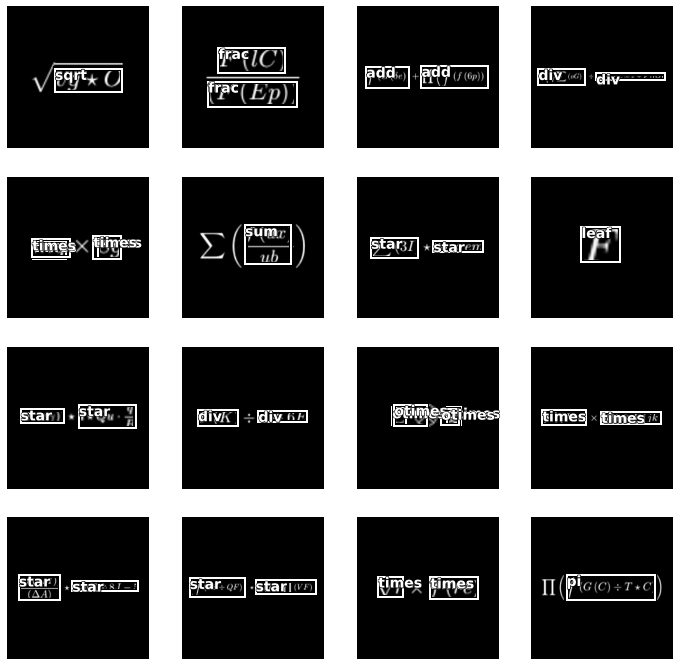

In [27]:
learn.show_results(max_n=20)

# ITL model inference

In [28]:
class Predictor():
    def __init__(self, learn: Learner):
        self.learn = learn

        self.labeler, self.point_scaler, self.to_tensor = learn.dls.valid.after_item
        self.scale_pixels = learn.dls.valid.after_batch[0]

        self.tfms = [self.labeler, self.point_scaler, self.to_tensor, self.scale_pixels]

        self.loss = ITLLoss()
    
    def _transform_img(self, img: PILImageBW) -> TensorImageBW:
        return self.scale_pixels(self.to_tensor(self.labeler(self.point_scaler(img))))[None]

    def _decode_after_fastai(self, boxes, cats):
        boxes = ((1 + boxes) / 2) * img.shape[1]
        
        x1, y1, x2, y2 = (boxes[0, :, i] for i in range(POINTS_PER_BBOX))
        boxes_coco = torch.stack((x1, y1, x2 - x1, y2 - y1), dim=-1)

        cat = self.learn.dls.vocab[cats[0, 0]]
        return boxes_coco, cat

    def _decode_preds(self, x):
        boxes, cats = self.loss.decodes(x)
        return self._decode_after_fastai(boxes, cats)


    def predict(self, img: PILImageBW):
        with torch.no_grad():
            preds = self.learn.model(to_device(self._transform_img(img), default_device()))

        return self._decode_preds(preds.cpu())

In [29]:
import abc
from dataclasses import dataclass
from typing import List

@dataclass
class Box:
    x: int
    y: int
    dx: int
    dy: int

@dataclass
class Operator:
    op_id: str

@dataclass
class Prediction:
    op: Operator
    bboxes: List[Box]

class Model(abc.ABC):
    @abc.abstractmethod
    def predict(self, input) -> Prediction:
        raise NotImplementedError

class ModelExample(Model):
    def predict(self, input) -> Prediction:
        return 'add', [Box(25, 25, 17, 17), Box(34, 34, 17, 17)]

class FastaiModelAdapter(Model):
    def __init__(self, predictor: Predictor):
        self._pred = predictor

    def _box_from_tensor(self, box_tensor):
        return Box(*map(lambda x: int(x.round().item()), box_tensor))

    def _make_pred(self, boxes_tensor, cat):
        boxes = [self._box_from_tensor(boxes_tensor[i])
            for i in range(boxes_tensor.shape[0])]

        return Prediction(
            op=Operator(cat),
            bboxes=boxes
        )

    def predict(self, input: PILImageBW) -> Prediction:
        return self._make_pred(*self._pred.predict(input))


In [30]:
pred = Predictor(learn)
fastai_model = FastaiModelAdapter(pred)

In [31]:
import cv2
from google.colab.patches import cv2_imshow

def resize_and_center_pred(full_img: PILImageBW, pred_bbox: Box) -> PILImageBW:
    def crop_img(image, bbox):
        proc = 0.03
        x_margin, y_margin = int(proc * bbox.dx), int(proc * bbox.dy) 
        return image[bbox.y:bbox.y + bbox.dy + y_margin, bbox.x:bbox.x + bbox.dx + x_margin]

    img_arr = np.array(full_img)
    img_cropped = crop_img(img_arr, pred_bbox)

    DIM, WHITE = 224, 255
    res = np.full((DIM, DIM), WHITE, dtype=np.uint8)

    y_shift = (DIM - img_cropped.shape[0]) // 2
    x_shift = (DIM - img_cropped.shape[1]) // 2
    
    res[y_shift:y_shift + img_cropped.shape[0], x_shift:x_shift + img_cropped.shape[1]] = img_cropped

    return PILImageBW.create(res)


# seq2seq model (for leaves)

PyTorch implementation of https://arxiv.org/abs/1609.04938v2
forked from [im2latex](https://github.com/ArminKaramzade/im2latex)

In [32]:
import os
import pickle
from collections import defaultdict
import torch
import glob
import sys
import cv2
import numpy as np
import datetime, pytz
from torchvision import transforms
from PIL import Image

class utils:
    class Vocab:
        def __init__(self, config):
            '''
                config: pathes, unk_threshold=2
            '''
            self.pathes = config['pathes']
            self.unk_threshold = config.get('unk_threshold', 2)
            self.token2idx = {}
            self.idx2token = {}
            self.load()

        def build(self):
            self.start_token = 0
            self.end_token = 1
            self.pad_token = 2
            self.unk_token = 3
            self.frequency = defaultdict(int)
            self.total = 0
            for path in self.pathes:
                formulas = open(path, 'r')
                lines = formulas.readlines()
                for line in lines:
                    tokens = line.rstrip('\n').strip(' ').split()
                    for token in tokens:
                        self.frequency[token] += 1
                        self.total += 1
            self.token2idx = {'<f>' : 0, '</f>' : 1, '<pad>' : 2, '<unk>' : 3}
            self.idx2token = {0 : '<f>', 1 : '</f>', 2 : '<pad>', 3 : '<unk>'}
            idx = 4
            for path in self.pathes:
                formulas = open(path, 'r')
                lines = formulas.readlines()
                for line in lines:
                    tokens = line.rstrip('\n').strip(' ').split()
                    for token in tokens:
                        if self.is_eligible(token) and token not in self.token2idx:
                            self.token2idx[token] = idx
                            self.idx2token[idx] = token
                            idx += 1
            # save vocab
            if not os.path.isdir('vocab'):
                os.mkdir('vocab')
            f = open(os.path.join('vocab', 'vocab.pkl'), 'wb')
            pickle.dump(self, f)
            f.close()

        def is_eligible(self, token):
            if self.frequency[token] >= self.unk_threshold:
                return True
            return False

        def load(self):
            try:
                with open(os.path.join('vocab', 'vocab.pkl'), 'rb') as f:
                    vocab = pickle.load(f)
                    self.token2idx = vocab.token2idx
                    self.idx2token = vocab.idx2token
                    self.start_token = vocab.start_token
                    self.unk_token = vocab.unk_token
                    self.pad_token = vocab.pad_token
                    self.end_token = vocab.end_token
                    self.frequency = vocab.frequency
                    self.total = vocab.total
            except:
                self.build()

        def formulas2tensor(self, formulas, max_len):
            sz = max_len + 2
            tensor = np.zeros((len(formulas), sz))
            for i in range(tensor.shape[0]):
                tensor[i, 0] = self.start_token
                for j in range(len(formulas[i])):
                    tensor[i, j+1] = self.token2idx.get(formulas[i][j], self.unk_token)
                for j in range(len(formulas[i])+1, sz-1):
                    tensor[i, j] = self.pad_token
                tensor[i, sz-1] = self.end_token
            return tensor

        def tensor2formula(self, tensor, pretty=False, tags=True):
            if not pretty:
                if tags:
                    return ' '.join(self.idx2token[tensor[i]] for i in range(tensor.shape[0]))
                else:
                    return ' '.join(self.idx2token[tensor[i]] for i in range(tensor.shape[0])
                                    if self.idx2token[tensor[i]] not in ['<f>', '</f>', '<pad>'])
            else:
                s = ' '.join(self.idx2token[tensor[i]] for i in range(tensor.shape[0]))
                end = s.find('</f>')
                if end != -1 : end = end - 1
                s = s[4:end]
                s = s.replace('<pad>', '')
                s = s.replace('<unk>', '')
                return s

    class data_loader:
        def __init__(self, vocab, config, train=False):
            '''
                config: vocab, batch_size, images_path, formulas_path=None, sort_by_formulas_len=False, shuffle=False):
            '''
            self.vocab = vocab
            self.batch_size = config['batch_size']
            self.images_path = config['images_path']
            self.formulas_path = config.get('formulas_path', None)
            self.sort_by_formulas_len = config.get('sort_by_formulas_len', False)
            self.shuffle = config.get('shuffle', False)
            self.cursor = 0
            self.images = glob.glob(self.images_path + '/*.png')
            self.images.sort()
            self.images.sort(key=len)
            self.has_label = (self.formulas_path is not None)
            if self.has_label:
                with open(self.formulas_path, 'r') as f:
                    self.formulas = [line.rstrip('\n').strip(' ').split()
                                    for line in f.readlines()]
                assert(len(self.images) == len(self.formulas))
                assert(not (self.shuffle and self.sort_by_formulas_len))
                self.max_len = 0
                for formula in self.formulas: self.max_len = max(self.max_len, len(formula))
                if self.sort_by_formulas_len:
                    zipped = sorted(enumerate(self.formulas), key=lambda x: len(x[1]), reverse=True)
                    idx, self.formulas = zip(*zipped)
                    self.images = [self.images[i] for i in idx]
                if self.shuffle:
                    idx = np.random.permutation(len(self.formulas))
                    self.formulas = [self.formulas[i] for i in idx]
                    self.images = [self.images[i] for i in idx]
            if train:
                self.data_transforms = transforms.Compose([
                    transforms.Grayscale(num_output_channels=1),
                    transforms.RandomAffine(
                        degrees=5,
                        translate=(0.1, 0.1),
                        scale=(0.15, 1.1),
                        fillcolor=255
                    ),
                    transforms.ColorJitter(brightness=0.05, saturation=0.05),
                    transforms.ToTensor()
                ])
            else:
                self.data_transforms = transforms.Compose([
                    transforms.Grayscale(num_output_channels=1),
                    transforms.ToTensor()                            
                ])

        def get_next_batch(self):
            current_batch_size = min(self.batch_size, len(self.images)-self.cursor)
            if current_batch_size == 0: end_of_epoch = True
            if self.has_label:
                if self.sort_by_formulas_len:
                    max_batch_len = len(self.formulas[self.cursor])
                else:
                    max_batch_len = -1
                    for i in range(self.cursor, self.cursor+current_batch_size):
                        max_batch_len = max(max_batch_len, len(self.formulas[i]))
                batch_formulas_tensor = self.vocab.formulas2tensor(self.formulas[self.cursor:self.cursor+current_batch_size], max_batch_len)
            batch_imgs = []
            for i in range(current_batch_size):
                img = Image.open(self.images[self.cursor])
                img = self.data_transforms(img)
                batch_imgs.append(img)
                end_of_epoch = self.move_cursor()
            if self.has_label:
                return torch.stack(batch_imgs), batch_formulas_tensor, end_of_epoch
            else:
                return torch.stack(batch_imgs), end_of_epoch

        def move_cursor(self):
            self.cursor += 1
            if len(self.images) <= self.cursor:
                self.reset_cursor()
                return True
            return False

        # def normalize(self, image):
        #     return (image / 255.) * 2 - 1

        def reset_cursor(self):
            self.cursor = 0

    class Logger:
        def __init__(self, config):
            '''
                config: owner, log_dir, timezone
            '''
            self.owner = config['owner']
            self.log_dir = config['log_dir']
            if not os.path.isdir(os.path.dirname(self.log_dir)):
                os.mkdir(os.path.dirname(self.log_dir))
            self.timezone = config['timezone']
            self.log = open(self.log_dir, 'a')

        def __call__(self, message):
            tz = pytz.timezone(self.timezone)
            ts = pytz.utc.localize(datetime.datetime.utcnow()).astimezone(tz).strftime("%Y-%m-%d %H:%M:%S")
            print('[{}], {}: {}'.format(self.owner, ts, message))
            print('[{}], {}: {}'.format(self.owner, ts, message), file=self.log)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, params):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=params['conv1_c'],
                               kernel_size=params['conv1_k'], stride=params['conv1_s'],
                               padding=params['conv1_p'])

        self.pool1 = nn.MaxPool2d(kernel_size=params['pool1_k'], stride=params['pool1_s'],
                                  padding=params['pool1_p'])

        self.conv2 = nn.Conv2d(in_channels=params['conv1_c'], out_channels=params['conv2_c'],
                               kernel_size=params['conv2_k'], stride=params['conv2_s'],
                               padding=params['conv2_p'])

        self.pool2 = nn.MaxPool2d(kernel_size=params['pool2_k'], stride=params['pool2_s'],
                                  padding=params['pool2_p'])

        self.conv3 = nn.Conv2d(in_channels=params['conv2_c'], out_channels=params['conv3_c'],
                               kernel_size=params['conv3_k'], stride=params['conv3_s'],
                               padding=params['conv3_p'])

        self.conv3_bn = nn.BatchNorm2d(params['conv3_c'])

        self.conv4 = nn.Conv2d(in_channels=params['conv3_c'], out_channels=params['conv4_c'],
                               kernel_size=params['conv4_k'], stride=params['conv4_s'],
                               padding=params['conv4_p'])

        self.pool3 = nn.MaxPool2d(kernel_size=params['pool3_k'], stride=params['pool3_s'],
                                  padding=params['pool3_p'])

        self.conv5 = nn.Conv2d(in_channels=params['conv4_c'], out_channels=params['conv5_c'],
                               kernel_size=params['conv5_k'], stride=params['conv5_s'],
                               padding=params['conv5_p'])

        self.conv5_bn = nn.BatchNorm2d(params['conv5_c'])

        self.pool4 = nn.MaxPool2d(kernel_size=params['pool4_k'], stride=params['pool4_s'],
                                  padding=params['pool4_p'])

        self.conv6 = nn.Conv2d(in_channels=params['conv5_c'], out_channels=params['conv6_c'],
                               kernel_size=params['conv6_k'], stride=params['conv6_s'],
                               padding=params['conv6_p'])

        self.conv6_bn = nn.BatchNorm2d(params['conv6_c'])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.pool3(x)
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = self.pool4(x)
        x = F.relu(self.conv6_bn(self.conv6(x)))
        return x


In [34]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional, device):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.device = device
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size,
                            batch_first=True, bidirectional=bidirectional)

    def forward(self, x):
        # x -> (batch, time, encoder_input_size)
        outputs, (hn, cn) = self.lstm(x, self.init_hidden(x.shape[0]))
        # outputs: ecnoder hiddens -> (batch, time, directions x encoder_hidden_size)
        # hn, cn -> (#layers, batch, directions x encoder_hidden_size)
        return outputs, (self.cat_directions(hn), self.cat_directions(cn))

    def init_hidden(self, batch_size):
        if self.bidirectional:
            return (torch.zeros(2, batch_size, self.hidden_size, device=self.device),
                    torch.zeros(2, batch_size, self.hidden_size, device=self.device))
        else:
            return (torch.zeros(1, batch_size, self.hidden_size, device=self.device),
                    torch.zeros(1, batch_size, self.hidden_size, device=self.device))

    def cat_directions(self, h):
        if self.bidirectional:
            h = torch.cat([h[0:h.size(0):2], h[1:h.size(0):2]], 2)
        return h

class Embedding(nn.Module):
    def __init__(self, input_size, embedded_size, padding_idx):
        super(Embedding, self).__init__()
        self.embedding = nn.Embedding(input_size, embedded_size, padding_idx=padding_idx)

    def forward(self, x):
        # x: symbols id -> (batch, time)
        embedded = self.embedding(x)
        # embedded -> (batch, time, embedded_size)
        return embedded

class BahdanauAttention(nn.Module):
    def __init__(self, query_size, memory_size, hidden_size):
        '''
            query_size = decoder_hidden_size
            memory_size = encoder_hidden_size
        '''
        super(BahdanauAttention, self).__init__()
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.memory_layer = nn.Linear(memory_size, hidden_size, bias=False)
        self.alignment_layer = nn.Linear(hidden_size, 1, bias=False)

    def score(self, query, keys):
        query = self.query_layer(query) # (batch, 1, hidden_size)
        keys = self.memory_layer(keys) # (batch, time, hidden_size)
        alignments = self.alignment_layer(torch.tanh(query + keys)) # (batch, time, 1)
        return alignments

    def forward(self, query, keys):
        '''
            query: last hidden of top layer decoder -> (batch, 1, query_size)
            keys: encoder outputs -> (batch, time, memory_size)
            return context -> (batch, 1, memory_size),
                   weights -> (batch, 1, time)
        '''
        scores = self.score(query, keys) # (batch, time, 1)
        weights = F.softmax(scores, dim=1).transpose(1, 2) # (batch, 1, time)
        context = torch.bmm(weights, keys) # (batch, 1, memory_size)
        return context, weights

class AttnDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, encoder_hidden_size, output_size, device):
        super(AttnDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device
        self.lstm = nn.LSTM(input_size+hidden_size, hidden_size, batch_first=True)
        self.attn = BahdanauAttention(hidden_size, encoder_hidden_size, hidden_size)
        self.o = nn.Linear(2*hidden_size, hidden_size, bias=False)
        self.out = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x, hp, cp, op, encoder_outputs):
        # x -> (batch, 1, input_size)
        # op -> (batch, hidden_size)
        # hp, cp -> (#layers, batch, hidden_size)
        # encoder_outputs -> (batch, time, #directions*encoder_hidden_size)
        lstm_input = torch.cat([x, op.unsqueeze(dim=1)], dim=2) # (batch, 1, input_size + hidden_size)
        hidden, (hn, cn) = self.lstm(lstm_input, (hp, cp))
        # hidden -> (batch, 1, hidden_size)
        # (hn, cn) -> (#layers, batch, hidden_size)
        context, attn_weights = self.attn(hidden, encoder_outputs)
        # context -> (batch, 1, hidden_size)
        # attn_weights -> (batch, 1, time)
        o_input = torch.cat([hidden.squeeze(1), context.squeeze(1)], dim=1) # (batch, 2*hidden_size)
        on = torch.tanh(self.o(o_input))
        # next_o -> (batch, hidden_size)
        output = F.log_softmax(self.out(on), dim=1)
        # output: log softmax of symbol scores -> (batch, output_size)
        return output, (hn, cn), on, attn_weights

In [35]:
from torch import optim
import numpy as np

class GreedyDecoder:
    def __init__(self, model, max_len, hn, cn, on, encoder_outputs, device):
        self.model = model
        self.max_len = max_len
        self.hn = hn
        self.cn = cn
        self.on = on
        self.encoder_outputs = encoder_outputs
        self.device = device

    def generate(self, start_token):
        next_token = torch.Tensor([start_token]).long().to(self.device) # (1)
        b = self.encoder_outputs.shape[0]
        next_token = next_token.repeat(b) # (batch)
        logits = []
        preds = [next_token]
        attn_weights = []
        hn = self.hn
        cn = self.cn
        on = self.on
        for t in range(1, self.max_len):
            output, (hn, cn), on, attn_weight = self.model.decoder_step(next_token, hn, cn, on, self.encoder_outputs)
            attn_weights.append(attn_weight.squeeze(1))
            logits.append(output)
            next_token = output.argmax(dim=1) # (batch)
            preds.append(next_token)
        logits = [torch.zeros(logits[1].shape[0], logits[1].shape[1], device=self.device)] + logits
        logits[0][:, start_token] = 1
        logits = torch.stack(logits, dim=1)
        preds = torch.stack(preds, dim=1)
        attn_weights = torch.stack(attn_weights, dim=1)
        return preds, logits, attn_weights

class Model(nn.Module):
    def __init__(self, cnn, encoder, embedding, decoder, device):
        super(Model, self).__init__()
        self.cnn = cnn
        self.encoder = encoder
        self.embedding = embedding
        self.decoder = decoder
        self.device = device

        directions = 2 if self.encoder.bidirectional else 1

        self.init_h = nn.Linear(directions*self.encoder.hidden_size, self.decoder.hidden_size).to(self.device)
        self.init_o = nn.Linear(directions*self.encoder.hidden_size, self.decoder.hidden_size).to(self.device)

    def get_cnn_feature(self, x):
        '''
            input:
                > x: image (batch, 1, H, W)
            return:
                > cnn feature map (batch, C, H', W')
        '''
        x = self.cnn(x)
        return x

    def get_encoder_anotation_grid(self, x):
        '''
            input:
                > x: cnn feature map (batch, C, H', W')

            return:
                > encoder_outputs: top layer hidden states of encoder applied on H' row of x
                                   (batch, H', W', directions * encoder_hidden_size)
                > hn, cn: last hidden states of encoder applied on H' row of x
                          (#layers, batch, H', decoder_hidden_size)

        '''
        B, C, H_prime, W_prime = x.shape
        x = x.permute(0, 2, 3, 1).contiguous().view(B*H_prime, W_prime, C) # (batch * H', W', C)
        encoder_outputs, (hn, cn) = self.encoder(x)
        # encoder_outputs -> (batch * H', W', directions * encoder_hidden_size)
        # hn, cn -> (#layers, batch * H', directions * encoder_hidden_size)
        encoder_outputs = encoder_outputs.view(B, H_prime, W_prime, -1).contiguous()
        hn = hn.view(hn.shape[0], B, H_prime, -1).contiguous()
        cn = hn.view(hn.shape[0], B, H_prime, -1).contiguous()
        return encoder_outputs, (hn, cn)

    def add_positional_embedding(self, x):
        '''
            input:
                > x: (batch, W'*H', directions * encoder_hidden_size)
            return:
                > x + positional_embedding
        '''
        n_position = x.shape[1]
        emb_dim = x.shape[2]
        position_enc = np.array([
                        [pos / np.power(10000, 2 * (j // 2) / emb_dim) for j in range(emb_dim)]
                         for pos in range(n_position)])
        position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2])
        position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2])
        return x + torch.from_numpy(position_enc).type(torch.FloatTensor).to(self.device)

    def decoder_step(self, input_token, hp, cp, op, encoder_outputs):
        '''
            input:
                > input_token: one hot input token (batch)
                > hp, cp: previous states (#layers, batch, decoder_hidden_size)
                > op: previous o (batch, decoder_hidden_size)
                > encoder_outputs: top layer encoder states (batch, H'*W', directions * encoder_hidden_size)
            return:
                > output: log probability of next token (batch, vocab_size)
                > hn, cn: next hidden states (#layers, batch, decoder_hidden_size)
                > on: next (batch, decoder_hidden_size)
                > attn_weight: attention alignments (batch, 1, H'*W')
        '''
        token_embedding = self.embedding(input_token).unsqueeze(1) # (batch, 1, embedding_size)
        output, (hn, cn), on, attn_weight = self.decoder(token_embedding, hp, cp, op, encoder_outputs)
        return output, (hn, cn), on, attn_weight

    def forward(self, x, y, teacher_forcing_ratio):
        '''
            input:
                > x: image (batch, 1, H, W)
                > y: one hot formulas (batch, len)
                > teacher_forcing_ratio
            return:
                > logits: log probability of tokens (batch, len-1, vocab_size) [excluding start token]
        '''
        x = self.get_cnn_feature(x)

        encoder_outputs, (hn, cn) = self.get_encoder_anotation_grid(x)

        b, h, w, _ = encoder_outputs.shape
        encoder_outputs = encoder_outputs.view(b, h*w, -1).contiguous() # (batch, H'*W', directions * encoder_hidden_size)
        encoder_outputs = self.add_positional_embedding(encoder_outputs) # (batch, H'*W', directions * encoder_hidden_size)

        hn = torch.tanh(self.init_h(torch.mean(encoder_outputs, dim=1))) # (batch, decoder_hidden_size)
        hn = hn.view(1, hn.shape[0], hn.shape[1]).contiguous() # (1, batch, decoder_hidden_size)
        cn = torch.zeros(1, b, self.decoder.hidden_size, device=self.device) # (1, batch, decoder_hidden_size)
        on = torch.tanh(self.init_o(torch.mean(encoder_outputs, dim=1))) # (batch, decoder_hidden_size)

        next_token = y[:, 0] # (batch)
        logits = torch.zeros(y.shape[0], y.shape[1], self.decoder.output_size, device=self.device) # (batch, len, vocab_size)
        logits[:, 0, y[0, 0]] = 1
        for t in range(1, y.shape[1]):
            output, (hn, cn), on, attn_weight = self.decoder_step(next_token, hn, cn, on, encoder_outputs)
            logits[:, t, :] = output
            if teacher_forcing_ratio < torch.rand(1).item():
                next_token = output.exp().multinomial(1).squeeze(1) # (batch)
            else:
                next_token = y[:, t] # (batch)
        return logits

    def generate(self, x, start_token, max_len, method):
        '''
            input:
                > x: image (batch, 1, H, W)
                > start_token: start token index
                > max_len: length of all generated formulas would be eless than max_len
                > method: 'greedy' or 'beam-seach'
            return:
                > preds: generated sequences (batch, max_len)
                > logits: log probability of tokens (batch, max_len-1, vocab_size)
                > attn_weights: attention alignments (batch, max_len-1, H'*W')
        '''
        x = self.get_cnn_feature(x)
        encoder_outputs, (hn, cn) = self.get_encoder_anotation_grid(x)
        b, h, w, _ = encoder_outputs.shape
        encoder_outputs = encoder_outputs.view(b, h*w, -1)
        encoder_outputs = self.add_positional_embedding(encoder_outputs) # (batch, H'*W', directions * encoder_hidden_size)

        hn = torch.tanh(self.init_h(torch.mean(encoder_outputs, dim=1))) # (batch, decoder_hidden_size)
        hn = hn.view(1, hn.shape[0], hn.shape[1]).contiguous() # (1, batch, decoder_hidden_size)
        cn = torch.zeros(1, b, self.decoder.hidden_size, device=self.device) # (1, batch, decoder_hidden_size)
        on = torch.tanh(self.init_o(torch.mean(encoder_outputs, dim=1))) # (batch, decoder_hidden_size)

        if method == 'greedy':
            generator = GreedyDecoder(self, max_len, hn, cn, on, encoder_outputs, self.device)

        elif method == 'beam-search':
            raise NotImplementedError('beam-search method is not implemented yet.')
            generator = BeamSearchDecoder()

        preds, logits, attn_weights = generator.generate(start_token)
        return preds, logits, attn_weights


In [36]:
class Trainer:
    def __init__(self, model, train_loader, config):
        '''
            config: device, checkpoints_dir, log_dir, print_every_batch, clip
                    learning_rate, learning_rate_decay, learning_rate_decay_step, learning_rate_min
                    teacher_forcing_ratio, teacher_forcing_ratio_decay, teacher_forcing_ratio_decay_step, teacher_forcing_ratio_min
        '''
        self.model = model
        self.train_loader = train_loader
        self.device = config['device']

        self.criterian = nn.NLLLoss(ignore_index=train_loader.vocab.pad_token)
        self.optimizer = optim.Adam(self.model.parameters(), lr=config['learning_rate'])
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=config['learning_rate_decay_step'],
                                                    gamma=config['learning_rate_decay'])
        self.learning_rate_min = config['learning_rate_min']

        self.checkpoints_dir = config['checkpoints_dir']

        logger_config = {
            'owner': 'Trainer.py',
            'log_dir' : config['log_dir'],
            'timezone' : 'Iran',
        }
        self.logger = utils.Logger(logger_config)

        self.clip = config['clip']

        self.checkpoint_name = lambda id: 'snapshot-{:02d}.pt'.format(id)

        self.print_every_batch = config['print_every_batch']
        self.current_epoch = 0

        self.teacher_forcing_ratio = config['teacher_forcing_ratio']
        self.teacher_forcing_ratio_decay = config['teacher_forcing_ratio_decay']
        self.teacher_forcing_ratio_decay_step = config['teacher_forcing_ratio_decay_step']
        self.teacher_forcing_ratio_min = config['teacher_forcing_ratio_min']

    def train_one_epoch(self):
        self.logger('start training one epoch')
        self.model.train()
        epoch_ended = False
        batch_counter = 0
        epoch_loss = 0
        epoch_acc = 0
        predictions = []
        while not epoch_ended:
            x_train, y_train, epoch_ended = self.train_loader.get_next_batch()
            x_train = x_train.to(self.device)
            y_train = torch.from_numpy(y_train).long().to(self.device)
            self.optimizer.zero_grad()
            logits = self.model(x_train, y_train, self.teacher_forcing_ratio)
            loss = self.criterian(logits[:, 1:, :].contiguous().view(-1, logits.shape[-1]),
                                  y_train[:, 1:].contiguous().view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)
            self.optimizer.step()
            mask = (y_train != self.train_loader.vocab.pad_token)
            preds = logits.argmax(dim=2)
            acc = ((y_train == preds) * mask).sum().item() / mask.sum().item()
            if batch_counter % self.print_every_batch == 0:
                self.logger('Batch {}: loss={}, acc={}, lr={}'.format(batch_counter, loss, acc, get_lr(self.optimizer)))
            epoch_loss += loss.item()
            epoch_acc += acc
            for i in range(preds.shape[0]):
                pred = preds[i].cpu().numpy()
                predictions.append(self.train_loader.vocab.tensor2formula(pred, pretty=True))
            batch_counter += 1
        self.logger('Epoch finished, loss={} acc={}, lr={}'.format(epoch_loss/batch_counter, epoch_acc/batch_counter, get_lr(self.optimizer)))
        if get_lr(self.optimizer) > self.learning_rate_min:
            self.scheduler.step()
        if self.current_epoch % self.teacher_forcing_ratio_decay_step == 0:
            self.teacher_forcing_ratio = max(self.teacher_forcing_ratio_min,
                                            self.teacher_forcing_ratio_decay * self.teacher_forcing_ratio)
        self.current_epoch += 1
        self.logger('training one epoch finished.')
        return predictions, epoch_loss/batch_counter, epoch_acc/batch_counter

    def evaluate(self, eval_loader, method):
        self.logger('evaluation starts.')
        self.model.eval()
        start_token = self.train_loader.vocab.start_token
        max_len = self.train_loader.max_len
        predictions = []
        with torch.no_grad():
            epoch_ended = False
            batch_counter = 0
            epoch_loss = 0
            epoch_acc = 0
            while not epoch_ended:
                if eval_loader.has_label:
                    x_eval, y_eval, epoch_ended = eval_loader.get_next_batch()
                    y_eval = torch.from_numpy(y_eval).long().to(self.device)
                else:
                    x_eval, epoch_ended = eval_loader.get_next_batch()
                # x_eval = torch.from_numpy(x_eval).float().to(self.device)
                x_eval = x_eval.to(self.device)
                if eval_loader.has_label:
                    max_len = y_eval.shape[1]
                preds, logits, attn_weights = self.model.generate(x_eval, start_token, max_len, method)
                if eval_loader.has_label:
                    epoch_loss += self.criterian(logits[:, 1:, :].contiguous().view(-1, logits.shape[-1]),
                                                 y_eval[:, 1:].contiguous().view(-1))
                    mask = (y_eval != self.train_loader.vocab.pad_token)
                    acc = ((y_eval == preds) * mask).sum().item() / mask.sum().item()
                    epoch_acc += acc
                for i in range(preds.shape[0]):
                    pred = preds[i].cpu().numpy()
                    predictions.append(self.train_loader.vocab.tensor2formula(pred, pretty=True))
                batch_counter += 1
                if batch_counter % self.print_every_batch == 0:
                    self.logger('batch {} completed.'.format(batch_counter))
            self.logger('evaluation finished.')
            if eval_loader.has_label:
                return predictions, attn_weights, epoch_loss/batch_counter, epoch_acc/batch_counter
            else:
                return predictions, attn_weights

    def save(self, epoch, loss, acc):
        if not os.path.isdir(self.checkpoints_dir):
            os.mkdir(self.checkpoints_dir)
        torch.save({
            'epoch' : epoch,
            'acc' : acc,
            'loss' : loss,
            'model_state_dict' : self.model.state_dict(),
            'optimizer_state_dict' : self.optimizer.state_dict(),
            'scheduler_state_dict' : self.scheduler.state_dict(),
        }, os.path.join(self.checkpoints_dir, self.checkpoint_name(epoch)))
        self.logger('Epoch {} saved.'.format(epoch))
        return os.path.join(self.checkpoints_dir, self.checkpoint_name(epoch))

    def load(self, checkpoint_name, cpu=False):
        checkpoint = torch.load(checkpoint_name, map_location=torch.device('cpu') if cpu else None)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.current_epoch = checkpoint['epoch']
        self.logger('{} loaded.'.format(checkpoint_name))

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


In [37]:
def get_seq2seq_model(config, vocab, checkpoint_name, cpu=True):
    cnn_model = CNN(config['cnn_params']).to(config['device'])

    encoder_model = Encoder(config['cnn_params']['conv6_c'], config['encoder_hidden_size'],
                                    config['bidirectional'], config['device']).to(config['device'])
    vocab_size = len(vocab.token2idx.keys())
    embedding_model = Embedding(vocab_size, config['embedding_size'], vocab.pad_token).to(config['device'])

    decoder_model = AttnDecoder(config['embedding_size'], config['decoder_hidden_size'],
                                        config['encoder_hidden_size']*(2 if config['bidirectional'] else 1), vocab_size,
                                        config['device']).to(config['device'])

    model = Model(cnn_model, encoder_model, embedding_model, decoder_model, config['device'])

    checkpoint = torch.load(checkpoint_name, map_location=torch.device('cpu') if cpu else None)
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

In [38]:
seq2seq_config = {
    # ======================
    #        pathes
    # ======================

    'formulas_train_path' : 'train.txt',
    'formulas_validation_path' : 'validate.txt',
    'formulas_test_path' : 'test.txt',
    'images_train_path' : 'train_imgs',
    'images_validation_path' : 'val_imgs',
    'images_test_path' : 'test_imgs',

    'checkpoints_dir' : 'checkpoints/',

    'log_dir' : 'logs/log.txt',
    # ======================
    #   general parameters
    # ======================
    'batch_size' : 32,
    'epochs' : 40,
    'print_every_batch' : 100,
    'learning_rate' : 1e-3,
    'learning_rate_decay' : .5,
    'learning_rate_decay_step' : 3,
    'learning_rate_min': 1e-6,
    'teacher_forcing_ratio' : 1,
    'teacher_forcing_ratio_decay' : 0.95,
    'teacher_forcing_ratio_decay_step' : 2,
    'teacher_forcing_ratio_min': 0.7,
    'clip' : 5,
    'unk_token_threshold' : 10,
    'generation_method' : 'greedy', # or 'beam-search'
    'device' : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    # ======================
    #   CNN parameters
    # ======================
    'cnn_params' : {
        'conv1_c' : 64,
        'conv1_k' : (3, 3),
        'conv1_s' : (1, 1),
        'conv1_p' : (1, 1),

        'pool1_k' : (2, 2),
        'pool1_s' : (2, 2),
        'pool1_p' : (0, 0),

        'conv2_c' : 128,
        'conv2_k' : (3, 3),
        'conv2_s' : (1, 1),
        'conv2_p' : (1, 1),

        'pool2_k' : (2, 2),
        'pool2_s' : (2, 2),
        'pool2_p' : (0, 0),

        'conv3_c' : 256,
        'conv3_k' : (3, 3),
        'conv3_s' : (1, 1),
        'conv3_p' : (1, 1),

        'conv4_c' : 256,
        'conv4_k' : (3, 3),
        'conv4_s' : (1, 1),
        'conv4_p' : (1, 1),

        'pool3_k' : (2, 1),
        'pool3_s' : (2, 1),
        'pool3_p' : (0, 0),

        'conv5_c' : 512,
        'conv5_k' : (3, 3),
        'conv5_s' : (1, 1),
        'conv5_p' : (1, 1),

        'pool4_k' : (1, 2),
        'pool4_s' : (1, 2),
        'pool4_p' : (0, 0),

        'conv6_c' : 512,
        'conv6_k' : (3, 3),
        'conv6_s' : (1, 1),
        'conv6_p' : (1, 1),
    },
    # ======================
    #   seq2seq parameters
    # ======================
    'embedding_size' : 80,
    'decoder_hidden_size' : 512,
    'encoder_hidden_size' : 256,
    'bidirectional' : True,
}

In [39]:
!wget https://students.mimuw.edu.pl/~mt406390/machine_learning/armin/armin_aug_100k/snapshot-15.pt
!mv snapshot-15.pt models
model_weights_file = 'snapshot-15.pt'

--2020-11-02 17:22:22--  https://students.mimuw.edu.pl/~mt406390/machine_learning/armin/armin_aug_100k/snapshot-15.pt
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119714352 (114M)
Saving to: ‘snapshot-15.pt’

snapshot-15.pt      100%[===================>] 114.17M  3.66MB/s    in 22s     

2020-11-02 17:22:45 (5.14 MB/s) - ‘snapshot-15.pt’ saved [119714352/119714352]



In [40]:
!wget https://students.mimuw.edu.pl/~mt406390/machine_learning/vocab.pkl
!mkdir vocab
!mv vocab.pkl vocab

--2020-11-02 17:22:45--  https://students.mimuw.edu.pl/~mt406390/machine_learning/vocab.pkl
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2399 (2.3K)
Saving to: ‘vocab.pkl’

vocab.pkl           100%[===================>]   2.34K  --.-KB/s    in 0s      

2020-11-02 17:22:45 (74.1 MB/s) - ‘vocab.pkl’ saved [2399/2399]



In [41]:
def get_vocab():
    seq2seq_config['pathes'] = ''
    vocab = utils.Vocab(seq2seq_config)
    return vocab

In [42]:
vocab = get_vocab()

In [43]:
from pathlib import Path
models = Path('models')
mdl = get_seq2seq_model(seq2seq_config, vocab, str(models / model_weights_file), cpu=True)

In [44]:
class LatexProducerWrapper(Predictor):
    def __init__(self, learn: Learner, seq2seq_model, vocab, gen_method, max_len):
        super().__init__(learn)
        self.model = seq2seq_model
        self.vocab = vocab
        self.gen_method = gen_method
        self.max_len = max_len

    def _get_single_pred(self, img_tensor):
        with torch.no_grad():
            preds, logits, attn_weights = self.model.generate(
                img_tensor, self.vocab.start_token, self.max_len, self.gen_method
        )
        pred = preds[0].cpu().numpy()

        return vocab.tensor2formula(pred, pretty=True)

    def predict(self, img: PILImageBW):
        return self._get_single_pred(to_device(self._transform_img(img), default_device()))

seq2seq_wrap = LatexProducerWrapper(learn, mdl, vocab, 'greedy', max_len=50)

# Final inference

In [45]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

class Inference:
    def __init__(self, fastai_model: Model, leaf_producer: LatexProducerWrapper,
                leaf_threshold=None):
        self.model = fastai_model
        self.leaf_producer = leaf_producer
        self.MAX_DEPTH = 8
        self.leaf_threshold = self.MAX_DEPTH if leaf_threshold is None \
            else leaf_threshold

    def _show_pred(self, input: PILImageBW, pred: Prediction):
        print(f'pred: {pred.op.op_id}')
        for box in pred.bboxes:
            plt.gca().add_patch(Rectangle((box.x, box.y), box.dx, box.dy,linewidth=1,edgecolor='green',facecolor='none'))
        plt.imshow(input,  cmap='Greys_r')
        # plt.axis('off')
        plt.show()

    def __call__(self, input: PILImageBW, depth=0, debug=False) -> str:
        if depth >= self.MAX_DEPTH:
            raise ValueError('stack overflow - your model too bad bro')

        if depth >= self.leaf_threshold:
            return self.leaf_producer.predict(input)

        pred = self.model.predict(input)

        if debug:
            self._show_pred(input, pred)
            

        operands = ops_cfg[pred.op.op_id]['operands']
        latex = ops_cfg[pred.op.op_id]['latex']

        if operands == 0:
            return self.leaf_producer.predict(input)
        
        inputs = [resize_and_center_pred(input, pred.bboxes[i]) for i in range(operands)]

        return latex.format(*(self(inp, depth + 1, debug) for inp in inputs))

In [46]:
!wget https://students.mimuw.edu.pl/~mt406390/machine_learning/dataset_sota_1k_100_100_1-4.zip
!unzip -qq dataset_sota_1k_100_100_1-4.zip -d test_set/

--2020-11-02 17:22:46--  https://students.mimuw.edu.pl/~mt406390/machine_learning/dataset_sota_1k_100_100_1-4.zip
Resolving students.mimuw.edu.pl (students.mimuw.edu.pl)... 193.0.96.129, 2001:6a0:5001:1::3
Connecting to students.mimuw.edu.pl (students.mimuw.edu.pl)|193.0.96.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7614642 (7.3M) [application/zip]
Saving to: ‘dataset_sota_1k_100_100_1-4.zip’

dataset_sota_1k_100 100%[===================>]   7.26M  11.0MB/s    in 0.7s    

2020-11-02 17:22:47 (11.0 MB/s) - ‘dataset_sota_1k_100_100_1-4.zip’ saved [7614642/7614642]



In [47]:
import glob

test_set = Path('test_set')
test_images = glob.glob(str(test_set / 'test_imgs' / '*.png'))
test_images= sorted(test_images, key=lambda x: int(x.split('/')[-1].split('.')[0]))
print(len(test_images))

1000


# Recursive CNN Inference example

---



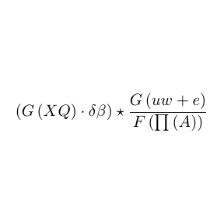

In [48]:
def img_from_path(path: Path) -> PILImageBW:
    return PILImageBW.create(path)

img = img_from_path(test_images[600])
img

pred: star


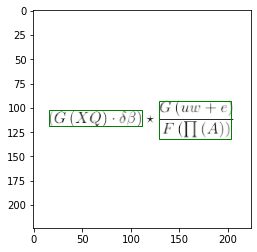

pred: par


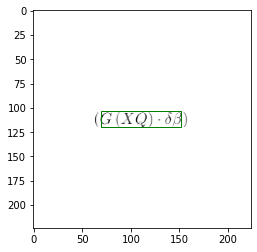

pred: mul


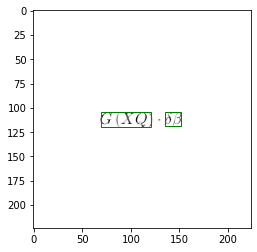

pred: gpar


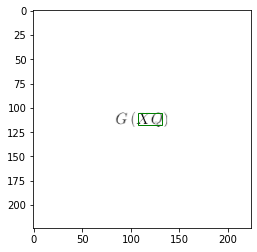

pred: leaf


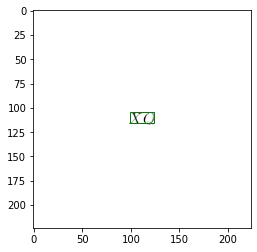

pred: leaf


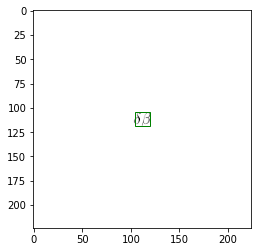

pred: frac


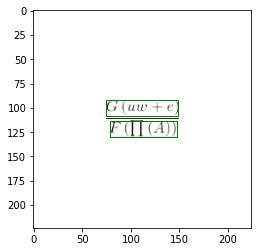

pred: gpar


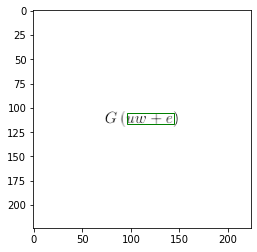

pred: add


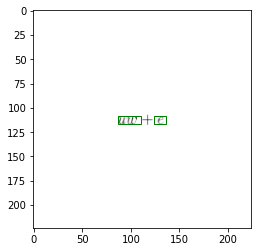

pred: leaf


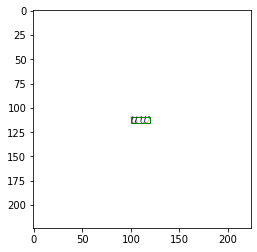

pred: leaf


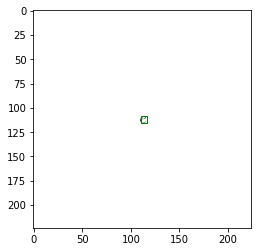

pred: ffpar


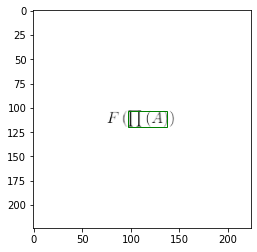

pred: pi


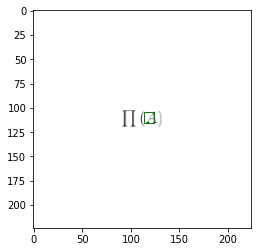

pred: leaf


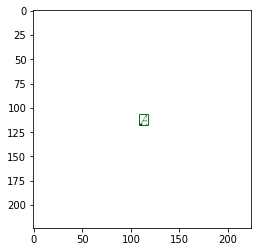

'\\left( G \\left( X O \\right) \\cdot \\delta \\beta \\right) \\star \\frac { G \\left( u w + e \\right) } { F \\left( \\prod \\left( \\frac { \\sqrt { y } } { x } \\right) \\right) }'

In [49]:
example_infer = Inference(fastai_model, seq2seq_wrap)
example_infer(img, debug=True)

In [50]:
!git clone https://github.com/kakainet/im2latex-1.git
!pip install -q distance

Cloning into 'im2latex-1'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 84 (delta 23), reused 20 (delta 9), pack-reused 38
Unpacking objects: 100% (84/84), done.
     |████████████████████████████████| 184kB 8.0MB/s 


In [51]:
import subprocess

preds_path = test_set / 'preds.txt'
predicted_path = test_set / 'test.txt'

def bleu_and_edit_distance(predictions, predicted_path, target_path):
    with open(predicted_path, 'w+') as f:
        for pred in predictions:
            f.write(pred+'\n')
    output = subprocess.check_output('python im2latex-1/src/Evaluation/bleu_score.py --target-formulas {} --predicted-formulas {} --ngram 5'.
                format(target_path, predicted_path), shell=True)
    output = str(output)
    bleu_message = output[output.find('BLEU'):-3]
    output = subprocess.check_output('python im2latex-1/src/Evaluation/edit_distance.py --target-formulas {} --predicted-formulas {}'.
                format(target_path, predicted_path), shell=True)
    output = str(output)
    edit_message = output[output.find('Edit'):-3]
    return bleu_message, edit_message

In [52]:
from tqdm import tqdm

def get_results(leaf_threshold):
    infer = Inference(fastai_model, seq2seq_wrap, leaf_threshold=leaf_threshold)

    predictions = [infer(img_from_path(img_path)) for img_path in tqdm(test_images)]

    return bleu_and_edit_distance(predictions, str(preds_path), str(predicted_path))

# Results

In [ ]:
# Vanilla seq2seq model
get_results(leaf_threshold=0)

100%|██████████| 1000/1000 [16:52<00:00,  1.01s/it]


('BLEU Score: 0.812304', 'Edit Distance Accuracy: 0.781447')

In [ ]:
# One prediction of our CNN model, then seq2seq model
get_results(leaf_threshold=1)

100%|██████████| 1000/1000 [25:35<00:00,  1.54s/it]


('BLEU Score: 0.891221', 'Edit Distance Accuracy: 0.854896')

In [ ]:
get_results(leaf_threshold=2)

100%|██████████| 1000/1000 [30:55<00:00,  1.86s/it]


('BLEU Score: 0.871733', 'Edit Distance Accuracy: 0.824075')

In [ ]:
get_results(leaf_threshold=3)

100%|██████████| 1000/1000 [40:18<00:00,  2.42s/it]


('BLEU Score: 0.832564', 'Edit Distance Accuracy: 0.755858')

In [ ]:
# CNN performs all predictions - seq2seq used only for leaves
get_results(leaf_threshold=4)

100%|██████████| 1000/1000 [44:22<00:00,  2.66s/it]


('BLEU Score: 0.802975', 'Edit Distance Accuracy: 0.682920')